In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error

#Load from csv file
file_path = 'hate_crime.csv'

#read into a DataFrame
all_data = pd.read_csv(file_path)

#Display the DataFrame
print(all_data)


C:\Users\eitan\AppData\Local\Temp\ipykernel_20164\1605876610.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


        incident_id  data_year        ori        pug_agency_name  \
0                43       1991  AR0350100             Pine Bluff   
1                44       1991  AR0350100             Pine Bluff   
2                45       1991  AR0600300      North Little Rock   
3                46       1991  AR0600300      North Little Rock   
4                47       1991  AR0670000                 Sevier   
...             ...        ...        ...                    ...   
241658      1473449       2022  WY0190200           Rock Springs   
241659      1473450       2022  WY0010200  University of Wyoming   
241660      1476554       2022  WY0190000             Sweetwater   
241661      1476555       2022  WY0110100               Cheyenne   
241662      1479088       2022  WY0190100            Green River   

       pub_agency_unit       agency_type_name state_abbr state_name  \
0                  NaN                   City         AR   Arkansas   
1                  NaN                   

In [3]:
# Print column titles
column_names = all_data.columns.tolist()
print(column_names)

['incident_id', 'data_year', 'ori', 'pug_agency_name', 'pub_agency_unit', 'agency_type_name', 'state_abbr', 'state_name', 'division_name', 'region_name', 'population_group_code', 'population_group_description', 'incident_date', 'adult_victim_count', 'juvenile_victim_count', 'total_offender_count', 'adult_offender_count', 'juvenile_offender_count', 'offender_race', 'offender_ethnicity', 'victim_count', 'offense_name', 'total_individual_victims', 'location_name', 'bias_desc', 'victim_types', 'multiple_offense', 'multiple_bias']


In [4]:
# Print all possible entries in "type"

type_options = set(all_data['bias_desc'])

print(type_options)

# Unique Types: Antismitic Incident, Extremist Murder, Anti-LGBTQ+ Incident, White Supremacist, Terrorist Plot/Attack, 

{'Anti-Multiple Races, Group;Anti-Other Christian', 'Anti-Black or African American;Anti-Multiple Religions, Group', 'Anti-Bisexual;Anti-Lesbian (Female)', 'Anti-Black or African American;Anti-Hispanic or Latino;Anti-Islamic (Muslim)', 'Anti-Catholic;Anti-Jewish', 'Anti-Black or African American;Anti-Lesbian (Female);Anti-Other Religion', 'Anti-Asian;Anti-Hispanic or Latino', 'Anti-Hispanic or Latino;Anti-Other Race/Ethnicity/Ancestry', 'Anti-Female;Anti-Mental Disability', 'Anti-Bisexual;Anti-Gay (Male);Anti-Gender Non-Conforming;Anti-Lesbian, Gay, Bisexual, or Transgender (Mixed Group);Anti-Transgender', 'Anti-Jewish;Anti-Lesbian (Female);Anti-Multiple Races, Group', 'Anti-Jewish;Anti-White', 'Anti-Other Christian;Anti-White', 'Anti-Arab;Anti-Heterosexual', 'Anti-Black or African American;Anti-Native Hawaiian or Other Pacific Islander', 'Anti-Asian;Anti-White', 'Anti-Female;Anti-Physical Disability', 'Anti-American Indian or Alaska Native;Anti-Asian;Anti-Black or African American;Ant

In [5]:
antisemitic_incidents = all_data[all_data['bias_desc'].str.contains("Anti-Jewish")].copy()
print(antisemitic_incidents.shape[0])

30469


In [6]:
#Get per year


def count_entries_by_year(incident_df, year):
    return antisemitic_incidents[antisemitic_incidents['data_year'] == year].copy().shape[0]


sum = 0
for year in range(1990, 2023):
    print(year, ": ", count_entries_by_year(antisemitic_incidents, year))
    sum += count_entries_by_year(antisemitic_incidents, year)
    
print(sum) 
print(antisemitic_incidents.shape[0])

1990 :  0
1991 :  795
1992 :  1020
1993 :  1141
1994 :  919
1995 :  1059
1996 :  1109
1997 :  1089
1998 :  1085
1999 :  1113
2000 :  1122
2001 :  1053
2002 :  938
2003 :  931
2004 :  965
2005 :  936
2006 :  968
2007 :  973
2008 :  1036
2009 :  932
2010 :  887
2011 :  770
2012 :  868
2013 :  630
2014 :  616
2015 :  667
2016 :  707
2017 :  984
2018 :  881
2019 :  1170
2020 :  977
2021 :  902
2022 :  1226
30469
30469


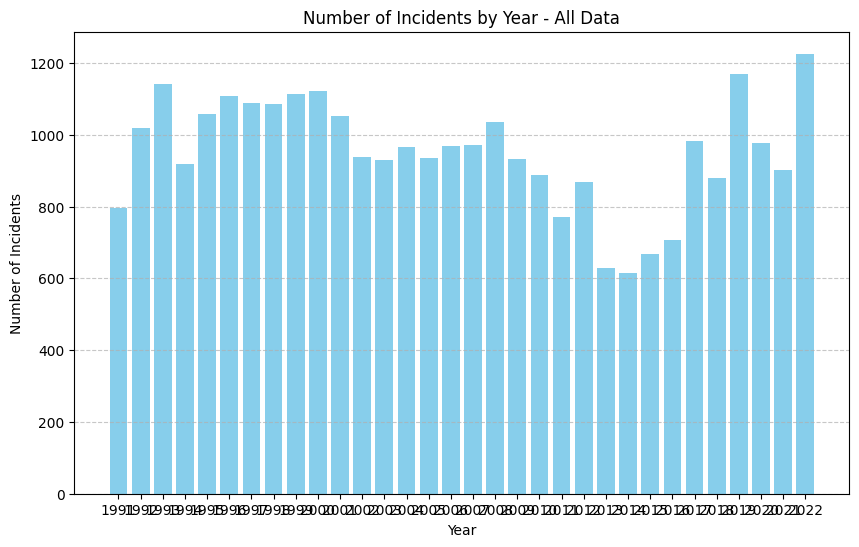

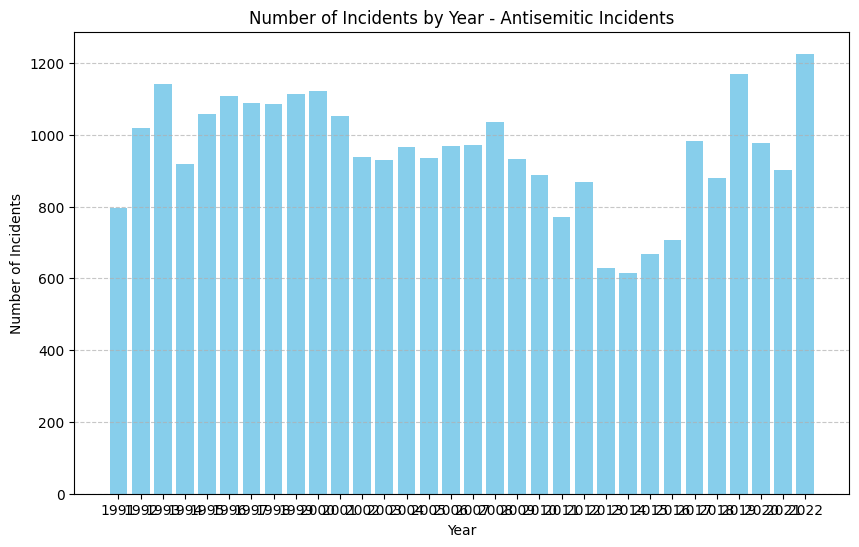

In [7]:
import pandas as pd
import matplotlib.pyplot as plt



def plot_incidents_by_year(incident_df, df_name):
    # Define years and corresponding counts
    years = range(1991, 2023)
    counts = [count_entries_by_year(incident_df, year) for year in years]

    # Create bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(years, counts, color='skyblue')
    plt.xlabel('Year')
    plt.ylabel('Number of Incidents')
    plt.title('Number of Incidents by Year - {}'.format(df_name))
    plt.xticks(years)  # Set x-axis ticks to be the years
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines
    plt.show()

plot_incidents_by_year(all_data, "All Data")
plot_incidents_by_year(antisemitic_incidents, "Antisemitic Incidents")


